In [1]:
import numpy as np
import requests
import os
import urllib
import tarfile

In [2]:
url = ' https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
filename = 'flower_photos.tgz'
urllib.request.urlretrieve(url, filename)

('flower_photos.tgz', <http.client.HTTPMessage at 0x1e612d95750>)

In [3]:
filename = 'flower_photos.tgz'
tf = tarfile.open(filename)
tf.extractall()

### You can check the number of images in each class using the code below.

In [4]:
flower_path = 'flower_photos'

classes = []
for class_names in os.listdir(flower_path):
    dir_path = os.path.join(flower_path, class_names)
    
    if os.path.isdir(dir_path):
        
        no_of_images = len(os.listdir(dir_path))
        print("Found {} image of {} class".format(no_of_images, class_names))
        
        classes.append(class_names)
        
classes.sort()
print(classes)

Found 633 image of daisy class
Found 898 image of dandelion class
Found 641 image of roses class
Found 699 image of sunflowers class
Found 799 image of tulips class
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Before we can pass the images to a deep learning model, we need to do some preprocessing, like resizing the image in the required shape, converting them to floating-point tensors, rescale the pixel values from 0-255 to 0-1 range as this helps in training.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='reflect')
datagen_test = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

In [7]:
train_data = datagen_train.flow_from_directory(flower_path,
                                              batch_size=64,
                                              subset='training',
                                              shuffle=True,
                                              seed=40,
                                              interpolation='bicubic',
                                              target_size = (224, 224))

test_data = datagen_test.flow_from_directory(flower_path,
                                            subset='validation',
                                            batch_size=64,
                                            target_size = (224, 224),
                                            shuffle=True,
                                            seed=40,
                                            interpolation='bicubic')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


# Visualize Images:
### It’s always a good idea to see what images look like in your dataset, so here’s a function that will plot new images from the dataset each time you run it.

In [8]:
import matplotlib.pyplot as plt
def image_show(data_generator, no=15):
    plt.figure(figsize=[25,25])
    data_batch, labels = next(data_generator)
    
    for i in range(no):
        plt.subplot(5,5,i+1)
        plt.imshow(data_batch[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

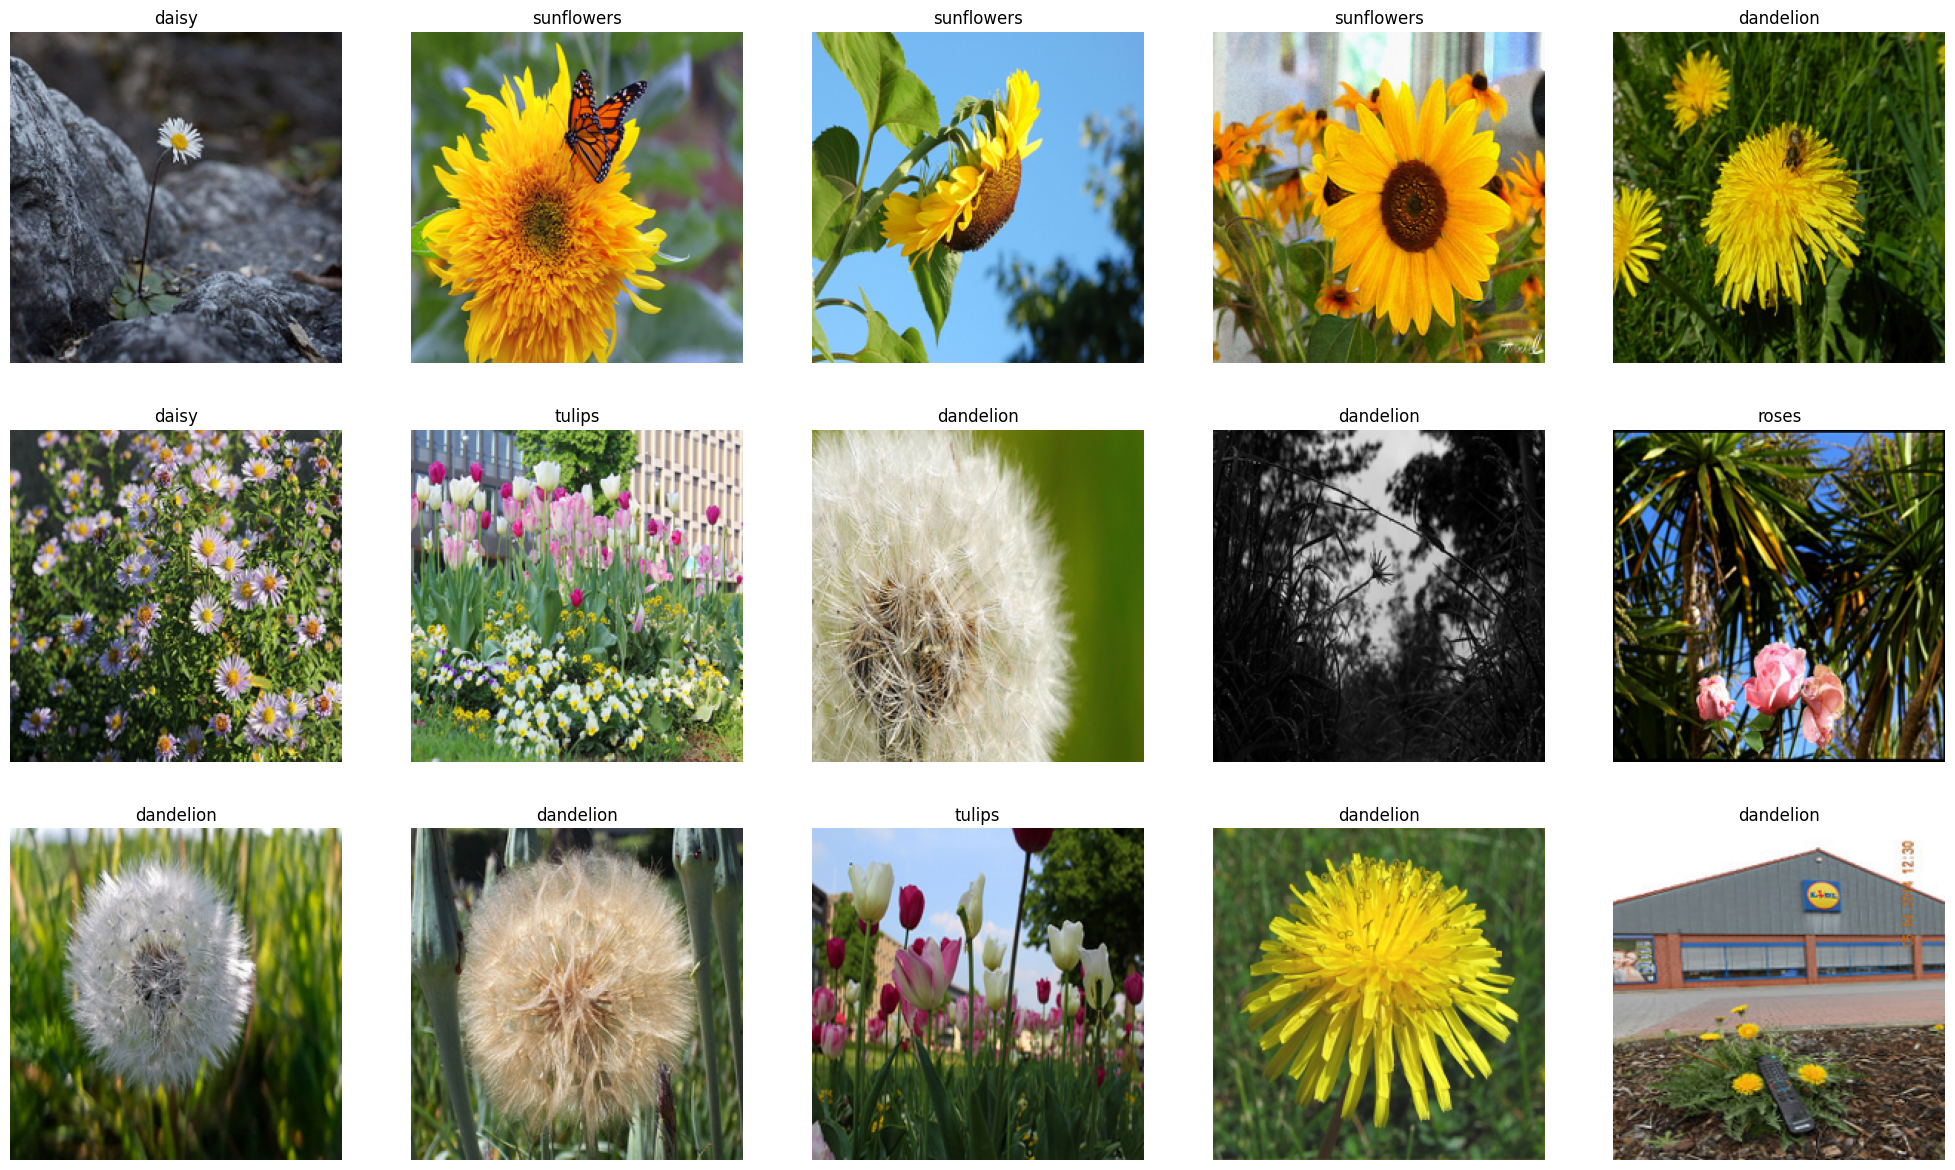

In [9]:
image_show(test_data)

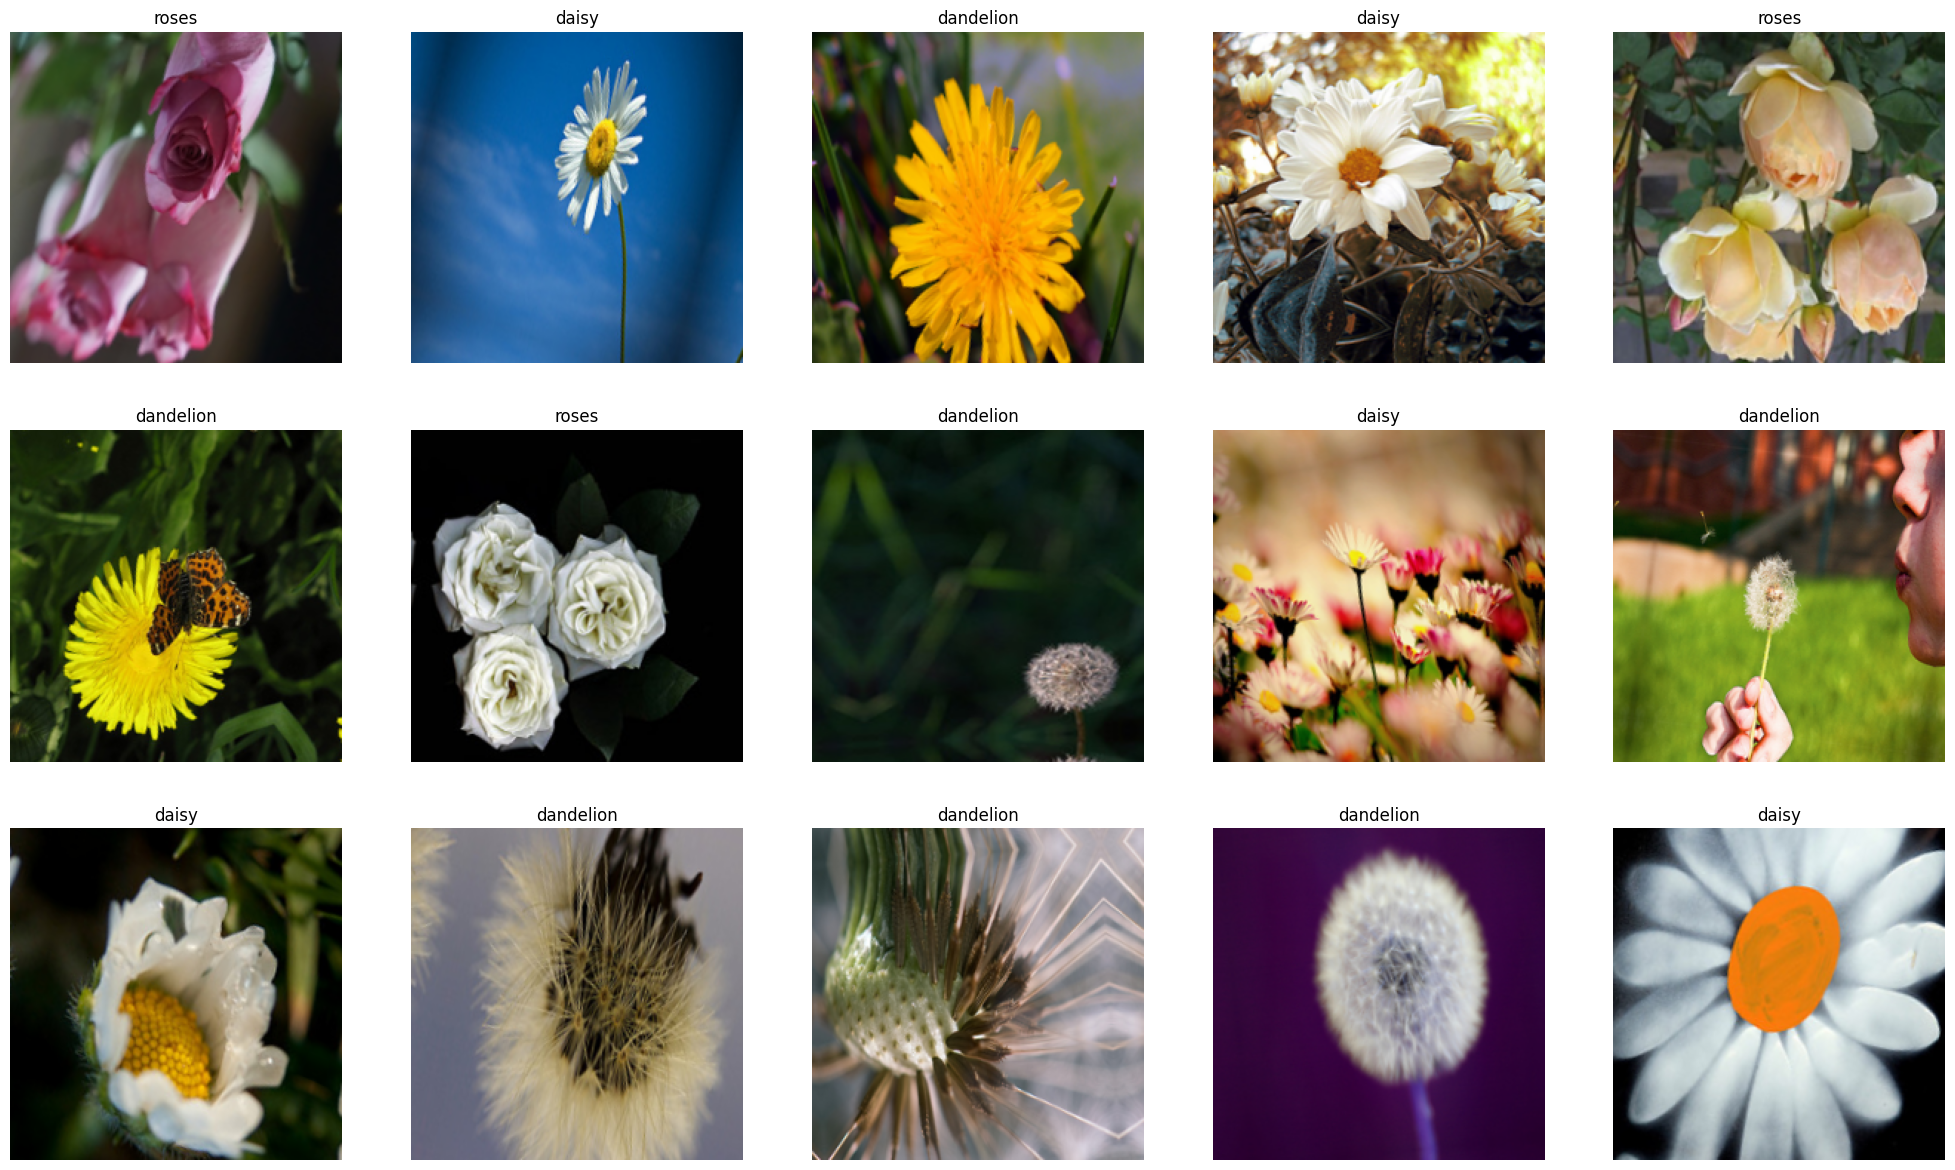

In [10]:
image_show(train_data)

In [11]:
print(len(train_data))
print(len(test_data))

46
12


In [12]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
train_data.reset()
test_data.reset()

model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Dropout(0.10),
    
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.10),
    # len(classes because we need get output same as length of classes)
    Dense(len(classes), activation='softmax')
])

Conv2D(16, 3, padding=’same’, activation=’relu’, input_shape =(IMG_HEIGHT, IMG_WIDTH ,3))

#### The number 16 refers to the number of filters in that layer, normally we increase the number of filters as you add more layers. You should notice that I double the number of filters in each subsequent convolutional layer i.e. 16, 32, 64 …, this is common practice. In the first layer, you also specify a fixed input shape that the model will accept, which we have already set as 200x200

#### Another thing you’ll see is that typically a convolutional layer is followed by a pooling layer. So the Conv layer outputs a number of feature maps and the pooling layer reduces the spatial size (width and height) of these feature maps which effectively reduces the number of parameters in the network thus reducing computation.

#### So you’ll commonly have a convolutional layer followed by a pooling layer, this is normally repeated several times, at each stage the size is reduced and the no of filters is increased. We are using a MaxPooling layer there are other pooling types too e.g. AveragePooling.

#### The Dropout layer randomly drops x% percentage of parameters from the network, this allows the network to learn robust features. In the network above I’m using dropout twice and so in those stages I’m dropping 10% of the parameters. The whole purpose of the Dropout layer is to reduce overfitting.

#### Now before we add the final layer we need to flatten the output in a single-dimensional vector, this can be done by the flatten layer but a better method is using the  GlobalAveragePooling2D Layer, which flattens the output while reducing the parameters.

#### Finally, before our last layer, we also use a Dense layer (A fully connected layer) with 1024 units. The final layer contains the number of units equal to the number of classes. The activation function here is softmax as I want the network to produce class probabilities at the end.

# Now Compile the model

### For this example, we are using the ADAM optimizer and a categorical cross-entropy loss function as we’re dealing with a multi-class classification problem. The only metric we care about right now is the accuracy of the model.

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

# Training the model
##### Epoch: A single epoch means 1 pass of the whole data meaning an epoch is considered done when the model goes over all the images in the training data and uses it for gradient calculation and optimizations. So this number decides how many times the model will go over your whole data.

##### Steps per epoch: A single step means the model goes over a single batch of the data, so steps per epoch tells, after how many steps should an epoch be considered done. This should be set to dataset_size / batch_size which is the number of steps required to go over the whole data once.

In [ ]:
batch_size = 64
history = model.fit(train_data, steps_per_epoch=train_data.samples // batch_size, epochs=50, validation_data=test_data,
                   validation_steps=test_data.samples // batch_size)

Epoch 1/50
45/45 [==============================] - 193s 4s/step - loss: 1.5145 - accuracy: 0.2873 - val_loss: 1.4299 - val_accuracy: 0.3210
Epoch 2/50
45/45 [==============================] - 144s 3s/step - loss: 1.2477 - accuracy: 0.4470 - val_loss: 1.2629 - val_accuracy: 0.4247
Epoch 3/50
45/45 [==============================] - 145s 3s/step - loss: 1.1324 - accuracy: 0.5169 - val_loss: 1.1254 - val_accuracy: 0.5426
Epoch 4/50
45/45 [==============================] - 143s 3s/step - loss: 1.0304 - accuracy: 0.5763 - val_loss: 1.0892 - val_accuracy: 0.5497
Epoch 5/50
45/45 [==============================] - 150s 3s/step - loss: 0.9628 - accuracy: 0.6000 - val_loss: 1.0507 - val_accuracy: 0.5866
Epoch 6/50
45/45 [==============================] - 146s 3s/step - loss: 0.9311 - accuracy: 0.6153 - val_loss: 0.9530 - val_accuracy: 0.6264
Epoch 7/50
45/45 [==============================] - 144s 3s/step - loss: 0.8677 - accuracy: 0.6588 - val_loss: 0.9618 - val_accuracy: 0.6179
Epoch 8/50
45

In [1]:
model.save('flowers.h5')

NameError: name 'model' is not defined

In [ ]:
# Later on you can load your model this way
#model = load_model('Model/flowers.h5')

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='training_acc')
plt.plot(epochs, val_acc, 'r', labek='validation acc')
plt.title('training acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', labek='validation loss')
plt.title('training acc')
plt.legend()

plt.show()

### You can test out the trained model on a single test image using this code. Make sure to carry out the same preprocessing steps you used before training for e.g. since we trained on normalized images in range 0-1, we will need to divide any new image with 255 before passing it to the model for prediction.

In [ ]:
img = cv.imread('rose.jpg')

# Resize the image to the size you trained on.
imgr = cv2.resize(imgr, (224, 224))

# Convert image BGR TO RGB, since OpenCV works with BGR and tensorflow in RGB.
imgbgr = cv2cvtCOLOR(imgr, cv2.COLOR_BGR2RGB)

# Normalize the image to be in range 0-1 and then convert to a float array.
final_format = np.array([imgbgr]).astype('float64') / 255.0

pred = model.predict(final_format)

# Get the index of top prediction
index = np.argmax(pred[0])

# Get the max probablity for that prediction
prob = np.max(pred[0])

# Get the name of the predicted class using the index
label = classes[index]

# Display the image and print the predicted class name with its confidence.
print("Predicted Flowers is : {} {:.2f}%".format(label, prob*100))
plt.imshow(img[:,:,::-1]);plt.axis("off");

#### Notice that we are converting our model from BGR to RGB color format. This is because TensorFlow has trained the model using images in RGB format whereas OpenCV reads images in BGR format, so we have to reverse channels before we can perform prediction.

# Part 2: Converting Our Classifier to ONNX format
##### Now that we have trained our model, it’s time to convert it to ONNX format.

##### ONNX stands for Open neural network exchange. ONNX is an industry-standard format for changing model frameworks, this means you can train a model in PyTorch or any other common frameworks and then convert to onnx and then convert back to TensorFlow or any other framework. 

##### So ONNX allows developers to move models between different frameworks such as CNTK, Caffe2, Tensorflow, PyTorch, etc.

##### So why are we converting to ONNX?

##### Remember our goal is to use the above custom trained model in the DNN module but the issue is the DNN module does not support using the .h5 Keras model directly. So we have to convert our .h5 model to a .onnx model after doing this we will be able to take the onnx model and plug it into the DNN module.

##### Note: Even if you saved the model in saved_model format then you still can’t use it directly 

In [20]:
import keras
import onnx

In [24]:
import keras2onnx

AttributeError: module 'tensorflow.python.keras' has no attribute 'applications'

In [ ]:
model = load_model()